# Report on EEG Attention Dataset Analysis

## Introduction

This report presents the analysis of an EEG dataset focused on attention levels. The analysis includes data preprocessing, training multiple machine learning models, and evaluating their performance. We will visualize various aspects of the data and the performance of the models.


In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score,classification_report
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping

# Load dataset
df = pd.read_csv(r"C:\Users\91981\Desktop\Project_EEG\EEg_Analysis\eeg_attention_reduced_correlation_dataset.csv")

# Drop 'Timestamp' and 'Subject ID' columns
df.drop(['Timestamp', 'Subject ID'], axis=1, inplace=True)

## 1. Distribution of 'Attention Level'

This plot shows the count of different categories in the 'Attention Level' column.


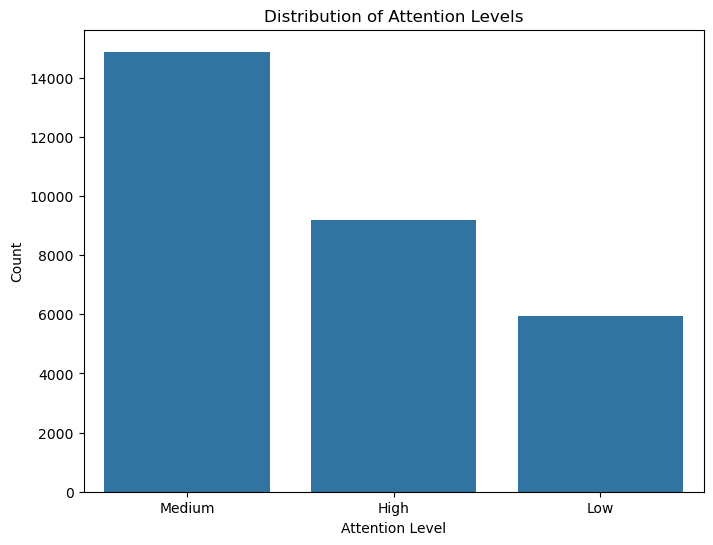

In [22]:
# Exploratory Data Analysis (EDA)
# 1. Distribution of 'Attention Level'
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='Attention Level')
plt.title('Distribution of Attention Levels')
plt.xlabel('Attention Level')
plt.ylabel('Count')
plt.show()

## Encoding Categorical Columns and 'Attention Level'

The categorical columns are one-hot encoded, and the 'Attention Level' column is label encoded to convert it into numerical format for further analysis.


In [23]:
# Encode categorical columns and 'Attention Level'
categorical_columns = ['Signal Quality', 'Task Difficulty', 'Mental Fatigue']
df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)
label_encoder = LabelEncoder()
df['Attention Level'] = label_encoder.fit_transform(df['Attention Level'])

## 2. Correlation Heatmap

This heatmap shows the correlations between different features in the dataset, helping to identify the strength and direction of linear relationships between variables.


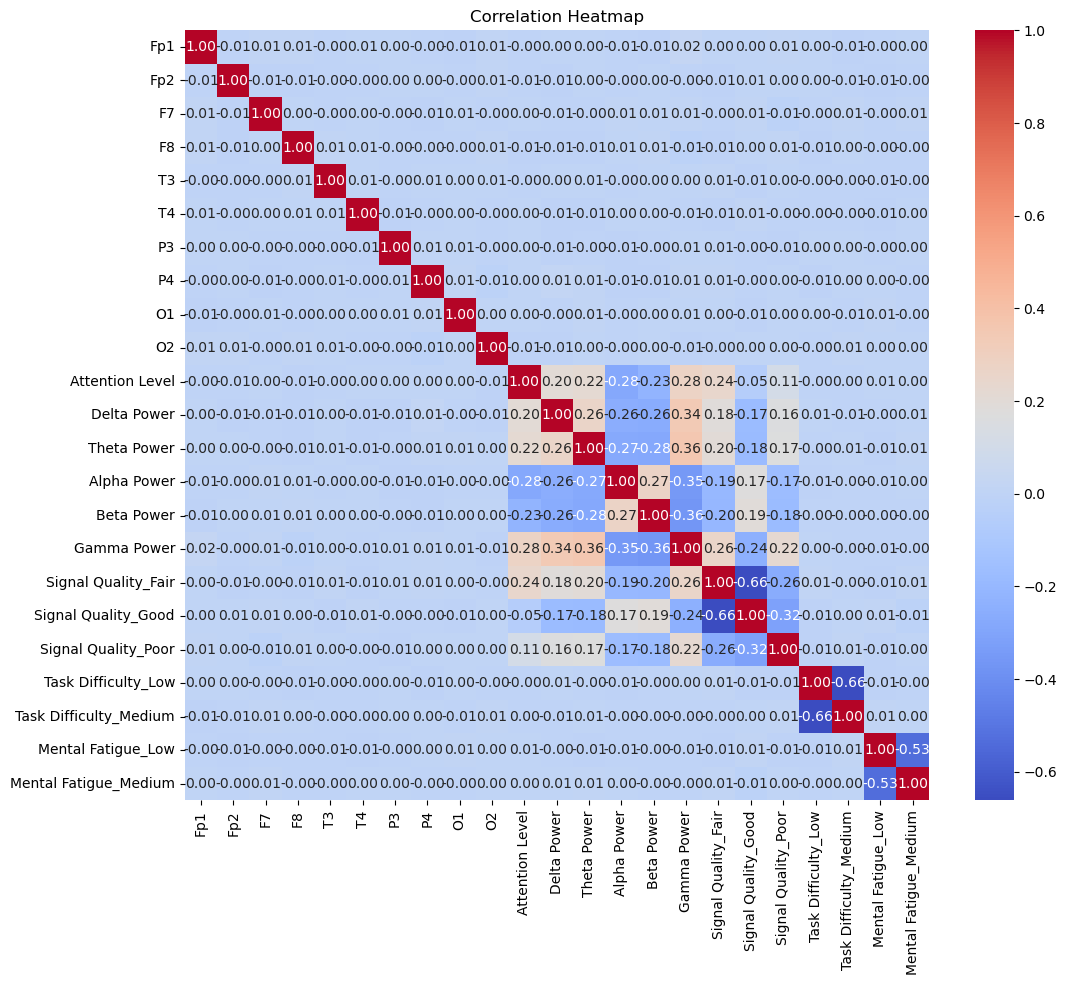

In [24]:

# 2. Correlation Heatmap
plt.figure(figsize=(12, 10))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

## Separating Features and Target Variable, Normalizing, and Splitting Data

The feature set is separated from the target variable ('Attention Level'), then normalized using MinMaxScaler. The dataset is split into training and testing sets with a 70-30 ratio to prepare for model training and evaluation.


In [25]:
# Separate features and target variable
X = df.drop('Attention Level', axis=1)
y = df['Attention Level']

# Normalize the feature set
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

## 4. Feature Importance from RandomForestClassifier

This section uses a RandomForestClassifier to determine the importance of each feature in predicting 'Attention Level'. The features are ranked based on their contribution to the model, and the importance is visualized using a bar plot.


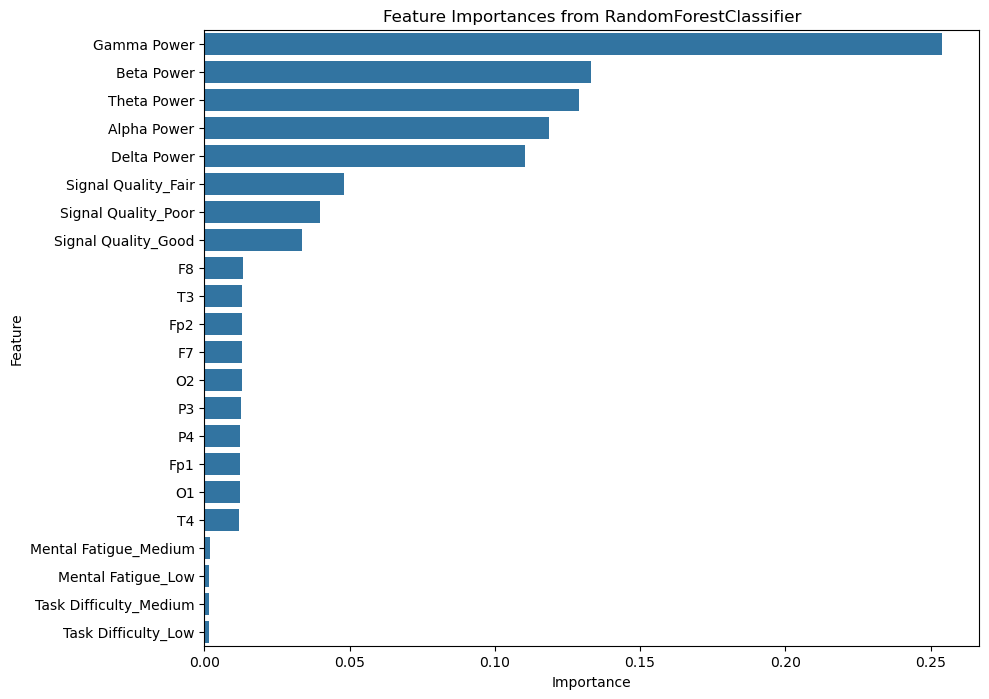

In [26]:
# 4. Feature Importance from RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=20, criterion='entropy', random_state=42)
rf_classifier.fit(X_train, y_train)
feature_importances = rf_classifier.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importances from RandomForestClassifier')
plt.show()


In [27]:
# Train and evaluate RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=20, criterion='entropy', random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred_rf = rf_classifier.predict(X_test)

print("RandomForestClassifier Results:")
print(confusion_matrix(y_test, y_pred_rf))
print("Accuracy:", accuracy_score(y_test, y_pred_rf))


RandomForestClassifier Results:
[[2539    0  208]
 [   0 1552  214]
 [ 360   33 4094]]
Accuracy: 0.9094444444444445


## Training and Evaluating RandomForestClassifier

A RandomForestClassifier is trained on the training data and then evaluated on the test data. The performance is measured using a confusion matrix and accuracy score to assess how well the model predicts 'Attention Level'.


In [28]:

# Train and evaluate XGBoostClassifier
xgb_classifier = xgb.XGBClassifier(random_state=42)
xgb_classifier.fit(X_train, y_train)
y_pred_xgb = xgb_classifier.predict(X_test)

print("XGBoostClassifier Results:")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))


XGBoostClassifier Results:
Confusion Matrix:
 [[2489    0  258]
 [   0 1567  199]
 [ 307   39 4141]]
Accuracy: 0.9107777777777778


## Training and Evaluating SVM

An SVM with a linear kernel is trained on the training data and evaluated on the test data. The performance is assessed using a confusion matrix and accuracy score to evaluate the model's effectiveness in predicting 'Attention Level'.


In [29]:

# Train and evaluate SVM
svm_classifier = SVC(kernel='linear', random_state=42)
svm_classifier.fit(X_train, y_train)
y_pred_svm = svm_classifier.predict(X_test)

print("SVM Results:")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_svm))
print("Accuracy:", accuracy_score(y_test, y_pred_svm))


SVM Results:
Confusion Matrix:
 [[2209    0  538]
 [   0 1455  311]
 [ 367  194 3926]]
Accuracy: 0.8433333333333334


## ANN using Keras

An Artificial Neural Network (ANN) is built with Keras, consisting of three hidden layers with ReLU activation and an output layer with softmax for multi-class classification. The model is trained with early stopping to prevent overfitting, monitoring validation loss and restoring the best weights.



In [30]:

# ANN using Keras
def build_ann_model(input_dim):
    model = Sequential()
    model.add(Dense(64, input_dim=input_dim, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(3, activation='softmax'))  # 3 classes for Attention Level

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Build and train ANN with Early Stopping
ann_model = build_ann_model(X_train.shape[1])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True,mode='min')

history = ann_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test,y_test),validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100


c:\Users\91981\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


657/657 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6741 - loss: 0.6936 - val_accuracy: 0.8201 - val_loss: 0.4081
Epoch 2/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8440 - loss: 0.3640 - val_accuracy: 0.8333 - val_loss: 0.3810
Epoch 3/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8407 - loss: 0.3643 - val_accuracy: 0.8390 - val_loss: 0.3689
Epoch 4/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8453 - loss: 0.3528 - val_accuracy: 0.8302 - val_loss: 0.3837
Epoch 5/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8502 - loss: 0.3490 - val_accuracy: 0.8417 - val_loss: 0.3588
Epoch 6/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8535 - loss: 0.3481 - val_accuracy: 0.8274 - val_loss: 0.3889
Epoch 7/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8516 - loss: 0.3471 - val_accuracy: 0.8418 - val_loss: 0.3597
Epoch 8/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8540 - loss: 0.3381 - val_accuracy: 0.8437

## Plot Training & Validation Loss Values

This plot shows the loss curves for both training and validation data over epochs. It helps visualize how well the model is learning and whether it is overfitting or underfitting.


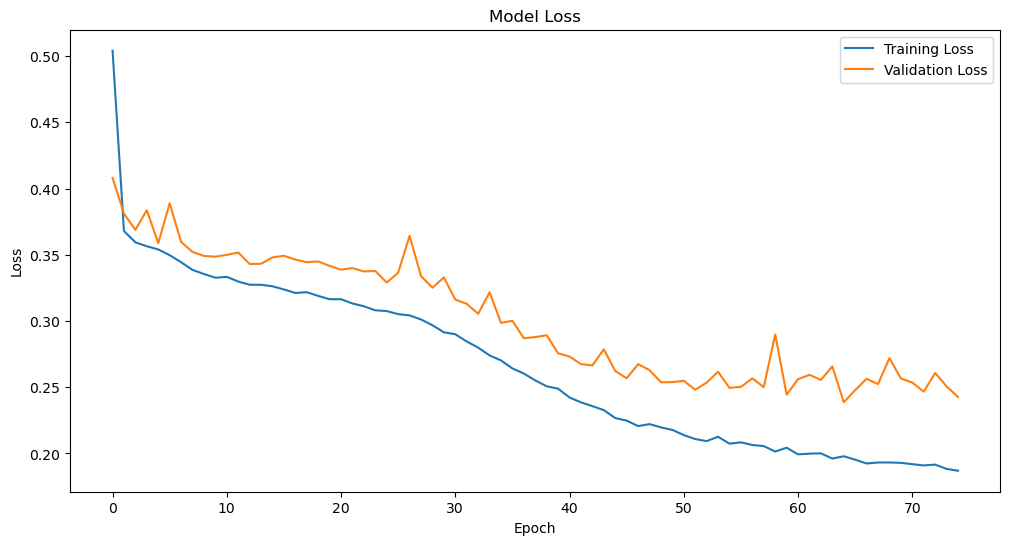

In [31]:

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()

## Plot Training & Validation Accuracy Values

This plot illustrates the accuracy of the model on both training and validation datasets over epochs. It helps to assess how well the model is performing and whether the training process is leading to improved accuracy.


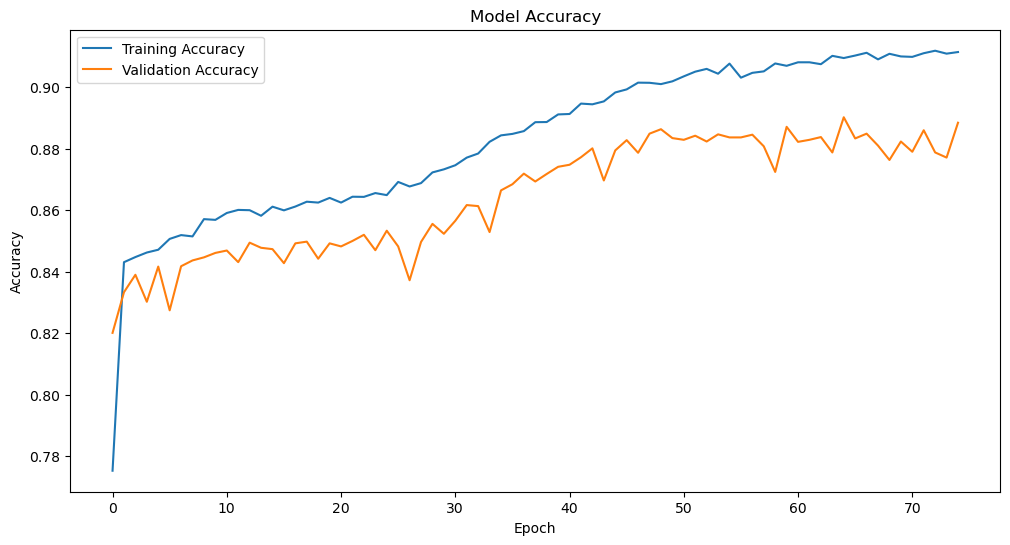

In [32]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.show()

## Evaluate ANN Model and Cross-Validation

The ANN model's performance is evaluated on the test set with a confusion matrix and accuracy score. Additionally, K-Fold Cross-Validation is performed to assess the stability and performance of RandomForestClassifier, XGBoostClassifier, and SVM across different subsets of the data.



In [33]:

# Evaluate ANN model
y_pred_ann = np.argmax(ann_model.predict(X_test), axis=1)

print("ANN Results:")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_ann))
print("Accuracy:", accuracy_score(y_test, y_pred_ann))

# Set up K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Collect cross-validation results
cv_results_rf = cross_val_score(rf_classifier, X_scaled, y, cv=kf, scoring='accuracy')
cv_results_xgb = cross_val_score(xgb_classifier, X_scaled, y, cv=kf, scoring='accuracy')
cv_results_svm = cross_val_score(svm_classifier, X_scaled, y, cv=kf, scoring='accuracy')

print("RandomForestClassifier Cross-Validation Accuracy:", np.mean(cv_results_rf))
print("XGBoostClassifier Cross-Validation Accuracy:", np.mean(cv_results_xgb))
print("SVM Cross-Validation Accuracy:", np.mean(cv_results_svm))

282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step
ANN Results:
Confusion Matrix:
 [[2517    0  230]
 [   1 1533  232]
 [ 432   93 3962]]
Accuracy: 0.8902222222222222
RandomForestClassifier Cross-Validation Accuracy: 0.9133333333333334
XGBoostClassifier Cross-Validation Accuracy: 0.9100333333333334
SVM Cross-Validation Accuracy: 0.8508333333333333


Project implements a hybrid machine learning model using a Stacking Classifier to combine Random Forest, XGBoost, and an Artificial Neural Network (ANN). The stacked model uses a Logistic Regression meta-model to improve overall prediction accuracy and robustness. This approach leverages the strengths of each individual algorithm for enhanced performance.

In [39]:
from scikeras.wrappers import KerasClassifier
from sklearn.ensemble import StackingClassifier
import tensorflow as tf
#Define the ANN model
def build_ann_model(input_dim):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(64, input_dim=input_dim, activation='relu'))
    model.add(tf.keras.layers.Dense(32, activation='relu'))
    model.add(tf.keras.layers.Dense(16, activation='relu'))
    model.add(tf.keras.layers.Dense(3, activation='softmax'))  # Assuming 3 classes
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Wrap the Keras model using SciKeras's KerasClassifier
keras_ann = KerasClassifier(model=build_ann_model, input_dim=X_train.shape[1], epochs=100, batch_size=32, verbose=0)

# Define other models (e.g., RandomForest and XGBoost)
rf_classifier = RandomForestClassifier()
xgb_classifier = xgb.XGBClassifier()

# Meta-model (Level 2) using Logistic Regression
meta_model = LogisticRegression()

# Create the StackingClassifier
stacking_model = StackingClassifier(
    estimators=[
        ('rf', rf_classifier),
        ('xgb', xgb_classifier),
        ('ann', keras_ann)  # Wrapped Keras ANN
    ],
    final_estimator=meta_model,
    cv=5
)

# Train the Stacking model
stacking_model.fit(X_train, y_train)

# Evaluate the Stacking model
y_pred_stack = stacking_model.predict(X_test)
print("Hybrid Model (Stacking) Results:")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_stack))
print("Accuracy:", accuracy_score(y_test, y_pred_stack))

c:\Users\91981\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\91981\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\91981\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs

Hybrid Model (Stacking) Results:
Confusion Matrix:
 [[2539    0  208]
 [   0 1575  191]
 [ 333   50 4104]]
Accuracy: 0.9131111111111111


In [42]:
print(classification_report(y_test, y_pred_stack))

              precision    recall  f1-score   support

           0       0.88      0.92      0.90      2747
           1       0.97      0.89      0.93      1766
           2       0.91      0.91      0.91      4487

    accuracy                           0.91      9000
   macro avg       0.92      0.91      0.92      9000
weighted avg       0.91      0.91      0.91      9000



## Conclusion

In this analysis, we employed a range of models to predict 'Attention Level,' including a hybrid **Stacking Classifier** that integrates **Random Forest**, **XGBoost**, and an **Artificial Neural Network (ANN)**. The performance of the hybrid model, along with its individual components, was evaluated as follows:

- **RandomForestClassifier**: Delivered feature importances and demonstrated its performance with accuracy and confusion matrix metrics.
- **XGBoostClassifier**: Assessed for its predictive accuracy and contribution to the ensemble.
- **Support Vector Machine (SVM)**: Evaluated with a linear kernel to determine its effectiveness in classification tasks.
- **Artificial Neural Network (ANN)**: Constructed and trained using Keras, with performance tracked through training and validation loss and accuracy metrics.

- **Hybrid Stacking Model**: Combined predictions from the Random Forest, XGBoost, and ANN models using a Logistic Regression meta-model. This approach aimed to leverage the strengths of each individual model for improved accuracy and robustness.

The results highlight the effectiveness of the stacking approach in enhancing predictive performance. This comprehensive analysis helps identify the most suitable model and ensemble strategy for predicting 'Attention Level' with greater accuracy and reliability.
